In [33]:
#Import Python packages that are used for water extent analysis.
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datacube.utils.geometry import Geometry
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.areaofinterest import define_area

In [34]:
#Connect to datacube for storing water extent using Sentinel2
dc = datacube.Datacube(app='water_extent')

In [35]:
create_local_dask_cluster()

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38075 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/parindapannoon@gmail.com/proxy/38075/status,
Dashboard: /user/parindapannoon@gmail.com/proxy/38075/status,Workers: 1
Total threads: 2,Total memory: 11.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42843,Workers: 1
Dashboard: /user/parindapannoon@gmail.com/proxy/38075/status,Total threads: 2
Started: Just now,Total memory: 11.21 GiB
Comm: tcp://127.0.0.1:45331,Total threads: 2
Dashboard: /user/parindapannoon@gmail.com/proxy/40779/status,Memory: 11.21 GiB
Nanny: tcp://127.0.0.1:42251,


In [36]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=0.632055, lon=36.05672 , buffer=0.12)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])


# Define the start year and end year
start_year = '2017'
end_year = '2021'

In [37]:
#Display map
display_map(lon_range, lat_range)

In [38]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-20, 20),
    'output_crs':'EPSG:6933',
    'time': (start_year, end_year),
    'dask_chunks':{'time':1,'x':500,'y':500}
}

#load Sentinel 2 data
ds = load_ard(dc=dc,
             products=['s2_l2a'],
             measurements=['green','swir_1'],
             mask_filters=[("opening", 3),("dilation", 2)], #improve cloud mask
             group_by='solar_day',
             **query)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 340 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 340, y: 1531, x: 1158)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2021-12-27T08:...
  * y            (y) float64 9.593e+04 9.591e+04 ... 6.535e+04 6.533e+04
  * x            (x) float64 3.467e+06 3.467e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [39]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf,da=ds, transform=ds.geobox.transform, crs=ds.crs)
#Mask the dataset to the rasterised area of interest
ds = ds.where(aoi_raster==1)

In [40]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index='MNDWI', satellite_mission='s2', drop=True)

Dropping bands ['green', 'swir_1']


In [ ]:
%%time
sample_frequency="AS"  #yearly resample 
#resample using medians
print('calculating MNDWI annual medians...')
mndwi = ds['MNDWI'].resample(time=sample_frequency).median().compute()

calculating MNDWI seasonal medians...


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [ ]:
#Plot MNDWI from the first and the last year in the data
mndwi.plot(col='time', col_wrap=5, cmap='Blues', vmax=1, vmin=-1);

In [ ]:
#Show the MNDWI value in data array
mndwi

In [ ]:
#Plot animation of annual MNDWI
out_path = 'water_extent.gif'
xr_animation(ds=mndwi.to_dataset(name='MNDWI'),
             output_path=out_path,
             bands = ['MNDWI'],
             show_text = 'Annual MNDWI',
             interval=500,
             width_pixels=300,
             show_colorbar=True,
             imshow_kwargs={'cmap':'RdBu','vmin': -0.5, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'}
            )

# Plot animated gif
plt.close()
Image(filename=out_path)

In [ ]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [ ]:
water = mndwi.where(mndwi > 0, np.nan)
area_ds = water.where(np.isnan(water),1)
ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

In [ ]:
#Plot average annual water extent
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Seasonal Area of Water from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

In [ ]:
ds_valid_water_area

In [14]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['2017-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


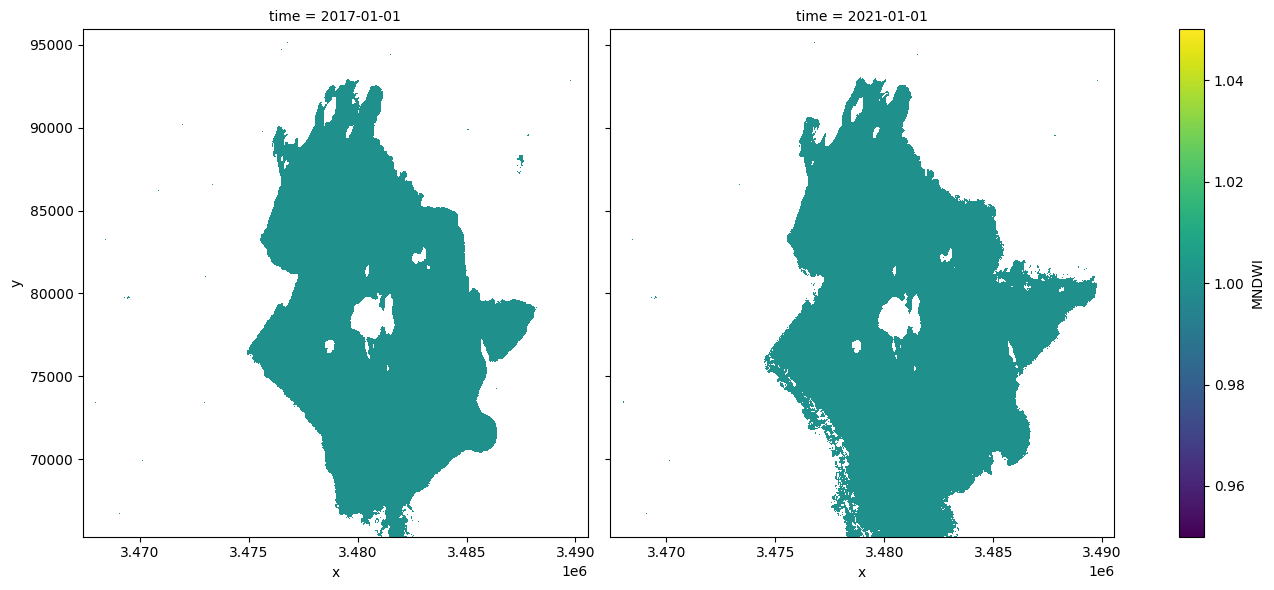

In [15]:
area_ds.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

In [16]:
baseline_time = '2017-01-01'
analysis_time = '2020-12-01'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

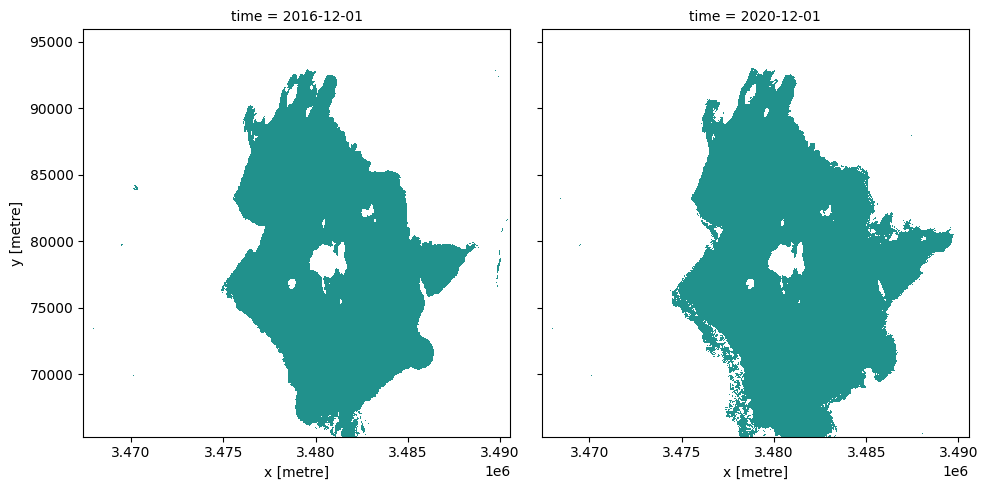

In [52]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis', add_colorbar=False);

In [53]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)

In [54]:
#Calculate area changes per pixel
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

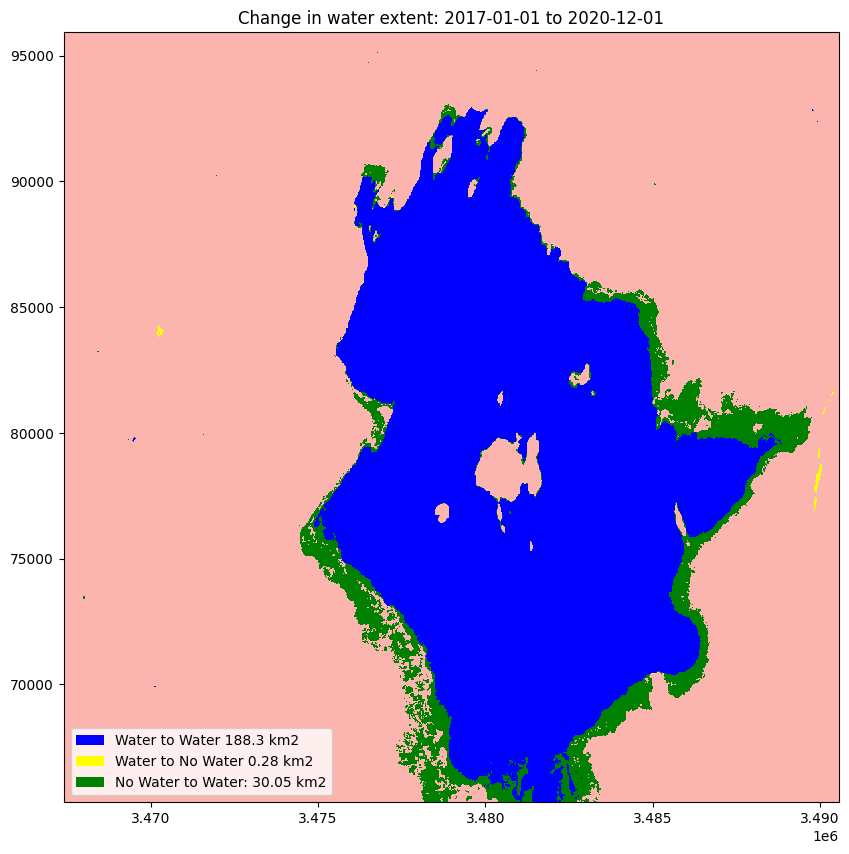

In [55]:
#Plot changes in water extent from 2017-2021
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ds_selected[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);